<a href="https://colab.research.google.com/github/spradeep97/cv_foundations/blob/master/2_Signal_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 504 PS2: Signal Processing

Pradeep Suresh, spradeep




# Starting

Run the following code to import the modules you'll need.

In [0]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, urllib, os
import scipy.ndimage # For image filtering
from scipy import signal
from scipy import fft
from scipy import fftpack
import imageio # For loading images
import cv2

# cv2.imshow does not work in Colab, we use cv2_imshow instead
from google.colab.patches import cv2_imshow

# Problem 2.1 2D DFT and convolution theorem 

2.1 (c) 

In this problem, we compare the output of a Gaussian filter through i) direct convolution in the spatial domain and ii) multiplication in the frequency domain.

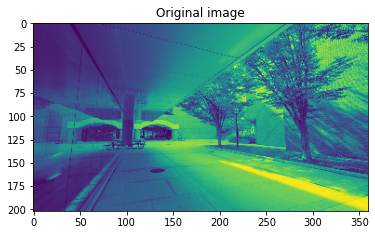

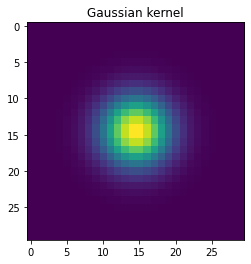

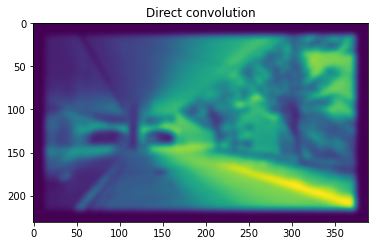

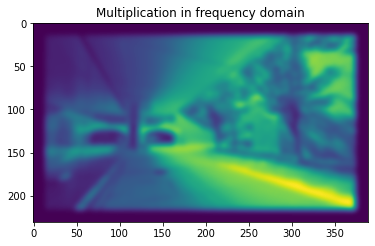

In [3]:
img_url = 'https://mapproxy.studentlife.umich.edu/images/electrical-engineering-and-computer-science-bld/XP2S3935.jpg'
with open('eecs.jpg', 'wb') as out:
  out.write(urllib.request.urlopen(img_url).read())

img = cv2.imread('eecs.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = cv2.resize(img, None, fx=0.25, fy=0.25)
plt.figure()
plt.imshow(img)
plt.title('Original image')
plt.show()

# make a 2-D kernel Gaussian kernel
t = np.linspace(-10, 10, 30)
bump = np.exp(-0.1*t**2)
bump /= np.trapz(bump) # normalize the integral to 1
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
plt.imshow(kernel)
plt.title('Gaussian kernel')
plt.show()

# convolution in spatial domain
# ===== your code here! =====
img1 = scipy.signal.convolve2d(img, kernel)
# ===== end of code =====
plt.figure()
plt.title('Direct convolution')
plt.imshow(img1)
plt.show()

# multiplication in frequency domain
# shape variable needs to be inputted to the fft2 function
shape = (img.shape[0]+kernel.shape[0]-1, img.shape[1]+kernel.shape[1]-1)
# ===== your code here! =====
img_fft = scipy.fft.fft2(img, shape)
kernel_fft = scipy.fft.fft2(kernel, shape)
conv_fft = img_fft * kernel_fft
img2 = abs(scipy.fft.ifft2(conv_fft))
# ===== end of code =====

plt.figure()
plt.title('Multiplication in frequency domain')
plt.imshow(img2)
plt.show()

# Problem 2.2 Image blending

(a) In this problem, we construct a Laplacian pyramids with 4 levels. We use the Laplacian pyramid to reconstruct the orignal image.

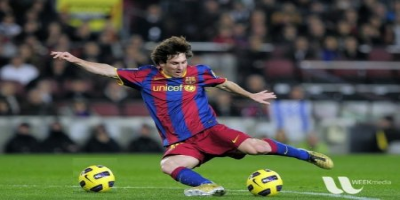

In [4]:
img_url = 'https://docs.opencv.org/master/roi.jpg'
with open('messi.jpg', 'wb') as out:
  out.write(urllib.request.urlopen(img_url).read())

img = cv2.imread('messi.jpg')
img = cv2.resize(img, (400,200))
cv2_imshow(img)

In [0]:
num_levels = 4 # including the original img

def pyr_up(p, kernel_size=(5,5)):
  '''
  Upsample the pyramid image to get the upper level. 

  Input:
    p: M x N x C array

  Return: 
    out: 2M x 2N x C array
  '''
  # ===== your code here! =====
  (rows,cols,channels) = p.shape
  out = np.zeros([2*rows,2*cols,channels])
  for i in range(rows):
      for j in range(cols):
          out[2*i, 2*j, :] = p[i,j,:]

  out = 4 * cv2.GaussianBlur(out,kernel_size,0)
  return out

def pyr_down(p, kernel_size=(5,5)):

    '''
    Downsample the pyramid image to get the lower level. 

    Input:
      p: M x N * C array

    Return: 
      out: M/2 x N/2 * C array
    '''
    # ===== your code here! =====
    (rows,cols,channels) = p.shape
    blur = cv2.GaussianBlur(p,kernel_size,0)
    out = np.zeros([rows//2,cols//2,channels])
    for i in range(rows//2):
      for j in range(cols//2):
        out[i, j, :] = blur[2*i,2*j,:]
    # ===== end of code =====
    return out

def gaussian_pyramid(img, num_levels):

  '''
  Input
    img: N x M x C array

  Return
    gp: list, the generated levels of the Gaussian pyramids
  '''

  # ===== your code here! =====
  gp = []
  kernel_size = (5,5)
  img_to_append = img
  for i in range(num_levels):
      gp.append(img_to_append)
      img_to_append = pyr_down(img_to_append, kernel_size)
  # ===== end of code =====

  return gp

def laplacian_pyramid(gp, num_levels):
  '''
  Input
    gp: list, Gaussian pyramids

  Return
    lp: list, Laplacian pyramids
  '''
  # ===== your code here! =====
  kernel_size = (5,5)
  lp = []
  for i in range(num_levels - 1):
      lp.append(gp[i] - pyr_up(gp[i+1]))
  # ===== end of code =====

  return lp

def reconstruct_img(lp,g_residue):
  '''
  reconstruct images using the laplacian pyramid.

  Input:
    lp: list, Laplacian pyramids

  Return:
    recon_img: array, reconstructed image
  '''
  recon_img = g_residue
  for i in range(len(lp)):
    # ===== your code here! =====
    recon_img = lp[-1-i] + pyr_up(recon_img)
    # ===== end of code =====

  return recon_img

Laplacian pyramid


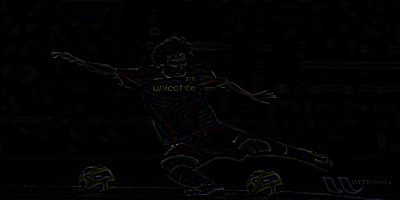

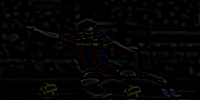

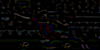

original image


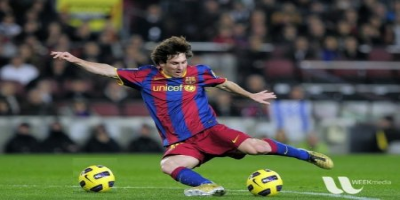

reconstructed image


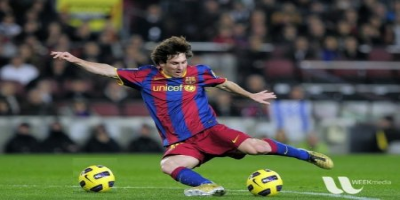

In [6]:
gp = gaussian_pyramid(img, num_levels)
lp = laplacian_pyramid(gp, num_levels)
recon_img = reconstruct_img(lp, gp[-1])

print('Laplacian pyramid')
for L in lp:
  cv2_imshow(L)

print('original image')
cv2_imshow(img)

print('reconstructed image')
cv2_imshow(recon_img)

# 2.2 (b) Blend two images


In [0]:
base_url = 'https://inst.eecs.berkeley.edu/~cs194-26/fa17/upload/files/proj3/cs194-26-acr/img/multires1/'
for name in ['orange.jpg', 'apple.jpg']:
  with open(name, 'wb') as out:
    url = os.path.join(base_url, name)
    out.write(urllib.request.urlopen(url).read())

In [0]:
img1 = cv2.imread('apple.jpg')
img2 = cv2.imread('orange.jpg')
img1 = cv2.resize(img1, None, fx=0.5, fy=0.5)
img2 = cv2.resize(img2, None, fx=0.5, fy=0.5)

mask = np.zeros_like(img1)
mask[:mask.shape[1]//2, :, :] = 1
inv_mask = np.ones_like(img1) - mask

In [0]:
def pyr_blend(img1, img2, mask, num_levels=6):
  '''
  This function produces the Laplacian pyramid blend of two images.

  Input
    type img1: N x M x C uint8 array
    type img2: N x M x C uint8 array
    type mask: N x M x C array, all elements are either 0s or 1s
    type num_level: int, height of the pyramids
  
  Return
    img_blend: N x M x C uint8 array
  '''
  img1 = img1.astype(float)
  img2 = img2.astype(float)
  # build Gaussian pyramids for img1, img2, and mask
  gp1, gp2, gpm, gpim = gaussian_pyramid(img1, num_levels), gaussian_pyramid(img2, num_levels), gaussian_pyramid(mask, num_levels), gaussian_pyramid(inv_mask, num_levels)

  # build Laplaican pyramids for img1 and img2 
  lp1, lp2, lpm, lpim = laplacian_pyramid(gp1, num_levels), laplacian_pyramid(gp2, num_levels), laplacian_pyramid(gpm, num_levels), laplacian_pyramid(gpim, num_levels)
 
  # blend two images starting from the level with lowest resolution


    # ===== your code here! =====
  gr_blend = np.multiply(gp1[-1],gpm[-1]) + np.multiply(gp2[-1], gpim[-1])
  lp_blend = []
  for i in range(num_levels - 1):
      lp_blend1 = np.multiply(lp1[i], gpm[i])
      lp_blend2 = np.multiply(lp2[i], gpim[i])
      lp_blend.append(lp_blend1 + lp_blend2)
  img_blend = reconstruct_img(lp_blend, gr_blend)
  # ===== end of code =====
  return img_blend

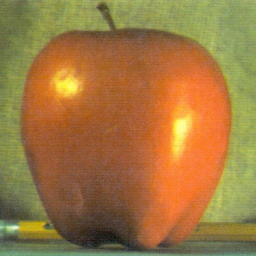

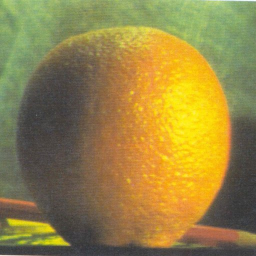

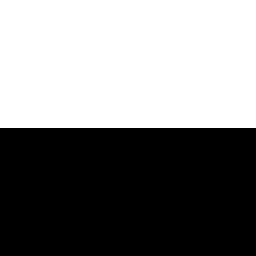

In [10]:
cv2_imshow(img1)
cv2_imshow(img2)
cv2_imshow(mask * 255)

Number of levels = 1


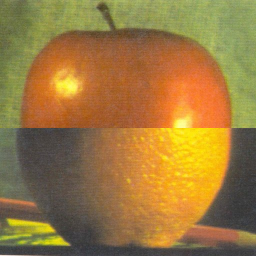

Number of levels = 2


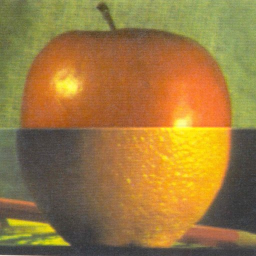

Number of levels = 3


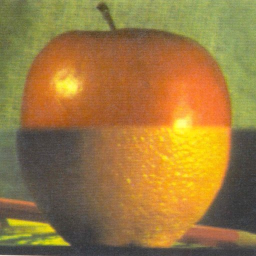

Number of levels = 4


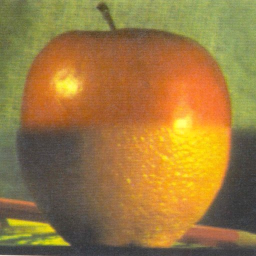

Number of levels = 5


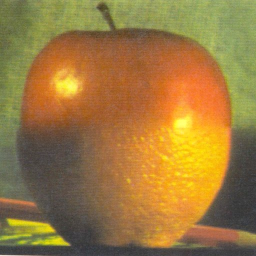

Number of levels = 6


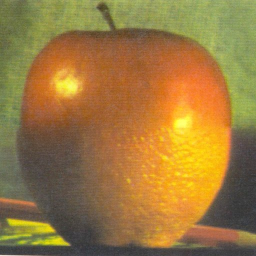

Number of levels = 7


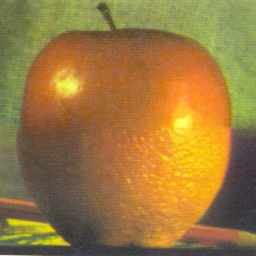

Number of levels = 8


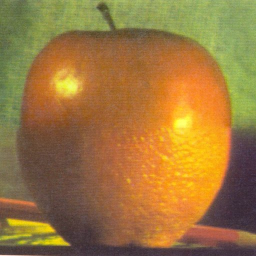

Number of levels = 9


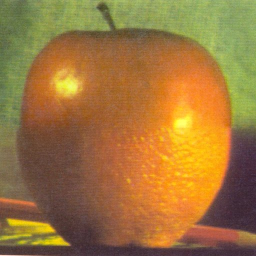

In [11]:
# Laplacian pyramid blend with different levels
 for n_l in range(1, 10):
    img_blend = pyr_blend(img1.astype(float), img2.astype(float), mask.astype(float), num_levels=n_l)
    print('Number of levels = {}'.format(n_l))
    cv2_imshow(img_blend)